# Best Subest Selection

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)

np.random.seed(20231031)

## Real Data

- Here we apply the best subset selection approach to the `Hitters` dataset.
- We wish to predict a baseball player’s `Salary` on the basis of various statistics associated with performance in the previous year.

In [2]:
Hitters = load_data('Hitters')
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [3]:
Hitters.shape, np.isnan(Hitters['Salary']).sum()

((322, 20), 59)

In [4]:
Hitters = Hitters.dropna()
Hitters.shape

(263, 20)

In [5]:
Hitters.isna().sum().sum()

0

- We first choose the "**best model**" using forward selection based on MSE.
- We need to specify the search strategy through the object `Stepwise()`  in the `ISLP.models` package. The method `Stepwise.first_peak()`
runs forward stepwise until any further additions to the model do not result in an improvement in the evaluation score. Similarly, the method `Stepwise.fixed_steps()`
runs a fixed number of steps of stepwise search.
- `.selected_state_` command outputs the best set of variables for each model size.

In [6]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)

In [7]:
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=len(design.terms))

In [8]:
hitters_MSE = sklearn_selected(OLS,
                               strategy)
hitters_MSE.fit(Hitters, Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

- Without specifying a `scoring` argument, the score defaults to MSE, and so all 19 variables will be
selected.
- `max_terms` option specifies the maximum number of features to select.

In [12]:
strategy = Stepwise.first_peak(design,
                               direction='forward',
                               max_terms=8)

hitters_MSE = sklearn_selected(OLS,
                               strategy)
hitters_MSE.fit(Hitters, Y)
hitters_MSE.selected_state_

('AtBat', 'CRBI', 'CRuns', 'CWalks', 'Division', 'Hits', 'PutOuts', 'Walks')

### Cross-validation for best subset selection

- We might try cross-validation to select a model in forward selection. For this, we need a method that stores the full path of models found in forward selection, and allows predictions for each of these. This can be done with the `sklearn_selection_path()` estimator from `ISLP.models`.

- Here we define a strategy that fits the full forward selection path. While there are various parameter choices for `sklearn_selection_path()`, we use the defaults here, which selects the model at each step based on the biggest reduction  in RSS.

In [69]:
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction='forward')
full_path = sklearn_selection_path(OLS, strategy)

In [19]:
nfolds = 10
n = Hitters.shape[0]

dat_idx = np.random.permutation(n)
cv_err = np.zeros((nfolds, 19))
for i in range(nfolds):
    idx_test = dat_idx[(i * n // nfolds + 1):((i + 1) * n // nfolds)]
    idx_train = np.setdiff1d(dat_idx, idx_test)

    full_path.fit(Hitters.iloc[idx_train, :], Y[idx_train])

    pred = full_path.predict(Hitters.iloc[idx_test, :])
    cv_err[i, :] = ((pred[:,1:] - Y[idx_test, None])**2).mean(0)

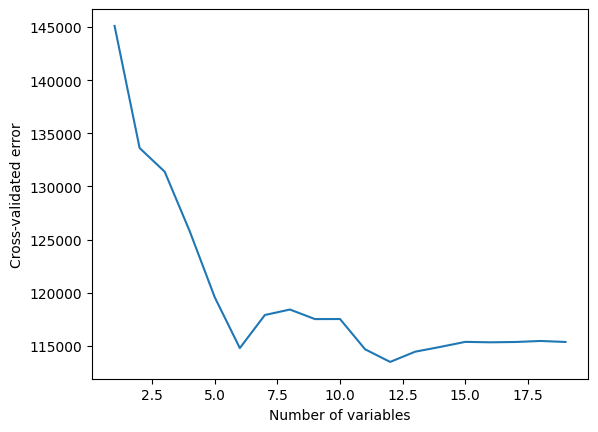

In [20]:
import matplotlib.pyplot as plt    

# Plot the cross-validated error as a function of the number of variables
plt.plot(range(1, 20), np.mean(cv_err, axis=0))
plt.xlabel('Number of variables')
plt.ylabel('Cross-validated error')
plt.show()

- Notice the expression `None` in `Y[:,None]` above. This adds an axis (dimension) to the one-dimensional array `Y`, which allows it to be recycled when subtracted from the two-dimensional `Yhat_in`.

### Other metrics to evaluate model performance

Recall: 
$$C_p=\frac{1}{n}(RSS+2d\hat{\sigma}^2)$$
$$AIC=\frac{1}{n}(RSS+2d\hat{\sigma}^2)$$
$$BIC=\frac{1}{n}(RSS+\log(n)d\hat{\sigma}^2)$$
$$adjR^2=1-\frac{RSS/(n-d-1)}{TSS/(n-1)}$$

### Take AIC as an example

In [54]:
strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction='forward')

full_path = sklearn_selection_path(OLS, strategy)

full_path.fit(Hitters, Y)
pred = full_path.predict(Hitters)

In [59]:
RSS = ((pred[:, 1:] - Y[:, None])**2).sum(0)
d = np.arange(1, 20) + 1 + 1 # Coefficients + intercept + error
sig_sq = RSS / n
aic = (RSS + 2 * d * sig_sq) / n

In [60]:
aic

array([140703.69268901, 120071.38646346, 115442.72783547, 111205.65931775,
       108726.77272575, 105659.73479158, 105439.35867168, 102937.19989552,
       102242.40115048, 101658.47766096, 101894.52962839, 102372.0253635 ,
       102888.87097695, 103418.50852078, 104061.75706603, 104694.21076502,
       105351.29138412, 106017.96642523, 106712.73783425])

In [64]:
np.argmin(aic)

9

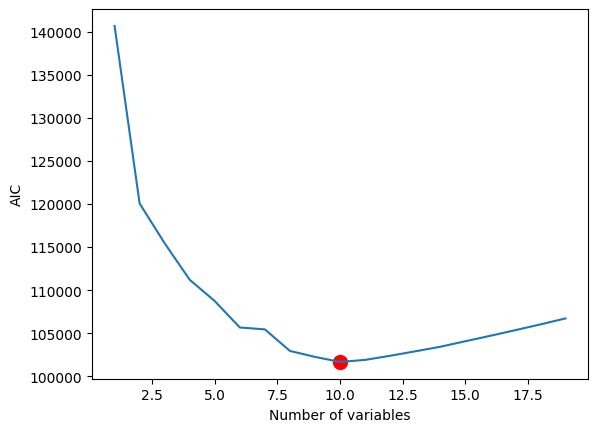

In [66]:
plt.plot(range(1, 20), aic)
plt.xlabel('Number of variables')
plt.ylabel('AIC')
plt.scatter(np.argmin(aic)+1, min(aic), c='red', s=100, marker='o')
plt.show()

## Simulation study

### A simple linear model

Suppose we have the data matrix $X \in \mathbb{R}^{N \times P}$ of $N$ samples and $P$ predictor variables and the response vector $y \in \mathbb{R}^{N \times 1}$.
Here only a few of the predictor variables have effects on $y$ while the remaining are redundant.
$X$ and $y$ follow the linear relationship
$$y = X \beta + \epsilon,$$
where $\epsilon$ are noise terms.

### Simple training and test scheme

- From $1$ to $\text{nrep}$,

    - Generate predictor variables $X$ and true response variable $y_0$.

    - Split the whole dataset into training and test sets.

    - For different $\text{SNR}$,
    
        - Generate noisy observations $y$.

        - Then we perform the best subset selection with the predictor size from $1$ to $P$ and evaluate the prediction accuracy using the test set.
    
    - End.
  
- End.

In [68]:
N = 300
ntrain = 100 # 100 for training
ntest = 200 # 200 for test
P = 25
p_true = 5
SNR_vec = [0.1, 0.3, 0.5, 0.7] # We will evaluate the performances under different SNR settings
nrep = 50 # Repeat 50 times for each setting

beta = np.zeros(P)
beta[:p_true] = 1 # The first p_true predictors have non-zero effects

X = np.random.rand(N, P)
X = pd.DataFrame(X, columns=[f"X{i}" for i in range(1, P+1)])
y0 = X.dot(beta)
err = pd.DataFrame()

In [94]:
for i in range(1, nrep+1):
    train_idx = np.random.choice(N, ntrain, replace=False)
    for j in range(len(SNR_vec)):
        SNR = SNR_vec[j]
        y = y0 + np.random.normal(0, np.sqrt(np.var(y0) / SNR), N)
        data_train = pd.concat([pd.DataFrame(y[train_idx], columns=["y"]), X.iloc[train_idx, :]], axis=1)
        data_test = pd.concat([pd.DataFrame(y[~np.isin(np.arange(N), train_idx)], columns=["y"]), X.iloc[~np.isin(np.arange(N), train_idx), :]], axis=1)
        #
        design = MS(data_train.columns.drop('y')).fit(data_train)
        strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction='forward')

        full_path = sklearn_selection_path(OLS, strategy)
        
        full_path.fit(data_train, data_train.iloc[:,0])
        pred = full_path.predict(data_test)
        
        for p in range(1, P+1):
            err = err.append(pd.DataFrame({"Trial": i, "Size": p, "SNR": SNR, "Error":((pred[:, p] - data_test.iloc[:,0])**2).mean(0)}, index = [0]))

In [95]:
err["Size"] = pd.Categorical(err["Size"], categories=np.arange(1, P+1))
err["SNR"] = "SNR = " + err["SNR"].astype(str)
err

,Trial,Size,SNR,Error
0,1,1,SNR = 0.1,4.665084
0,1,2,SNR = 0.1,5.129166
0,1,3,SNR = 0.1,5.450299
0,1,4,SNR = 0.1,5.633416
0,1,5,SNR = 0.1,5.640688
...,...,...,...,...
0,50,21,SNR = 0.7,0.786924
0,50,22,SNR = 0.7,0.782857
0,50,23,SNR = 0.7,0.785261
0,50,24,SNR = 0.7,0.786212


/home/huangxr/anaconda3/envs/dl/lib/python3.9/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


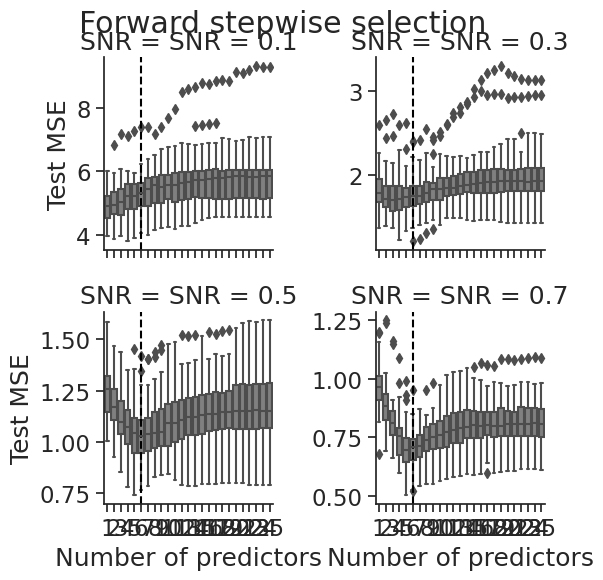

In [96]:
import seaborn as sns

sns.set(style="ticks", font_scale=1.5)
g = sns.FacetGrid(data=err, col="SNR", col_wrap=2, sharey=False)
g.map(sns.boxplot, "Size", "Error", color="gray")
g.map(plt.axvline, x=p_true, color="black", linestyle="--")
g.set_axis_labels("Number of predictors", "Test MSE")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Forward stepwise selection")
plt.show()

### Cross validation

- Generate predictor variables $X$ and true response variable $y_0$.

- Divide the whole dataset into $K$ folds.

- For different $\text{SNR}$,
  
    - Generate noisy observations $y$.

    - Each time use $K-1$ folds as the training set and perform the best subset selection with the predictor size from $1$ to $P$. Then evaluate the model performance using the remaining one as the test set.
  
- End.

In [97]:
N = 100
P = 25
p_true = 5
SNR_vec = [0.2, 0.4, 0.6, 0.8]

beta = np.zeros(P)
beta[:p_true] = 1

X = np.random.rand(N, P)
X = pd.DataFrame(X, columns=[f"X{i}" for i in range(1, P+1)])
y0 = X.dot(beta)

In [102]:
from sklearn.model_selection import KFold

In [118]:
nfolds = 10
dat_idx = np.arange(N)
err_cv = np.zeros((P, len(SNR_vec), nfolds))
for i in range(len(SNR_vec)):
    SNR = SNR_vec[i]
    y = y0 + np.random.normal(0, np.sqrt(np.var(y0) / SNR), N)
    dat = pd.concat([pd.DataFrame(y, columns=["y"]), X], axis=1)
    kf = KFold(n_splits = nfolds, shuffle=False)
    design = MS(dat.columns.drop('y')).fit(dat)
    strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction='forward')
    full_path = sklearn_selection_path(OLS, strategy)
    
    for k, (train_idx, test_idx) in enumerate(kf.split(dat)):
        
        full_path.fit(dat.iloc[train_idx, :], dat.iloc[train_idx, 0])
        pred = full_path.predict(dat.iloc[test_idx, :])
            
        err_cv[:, i, k] = ((pred[:, 1:] - np.array(dat.iloc[test_idx, 0]).reshape(len(test_idx),1))**2).mean(0)

In [121]:
err_cv = pd.DataFrame(err_cv.mean(axis=2), columns=["SNR = "+str(s) for s in SNR_vec])
err_cv["Size"] = np.arange(1, P+1)
err_cv = pd.melt(err_cv, id_vars=["Size"], var_name="SNR", value_name="Test error")

In [122]:
err_cv

,Size,SNR,Test error
0,1,SNR = 0.2,2.864937
1,2,SNR = 0.2,3.199013
2,3,SNR = 0.2,3.338457
3,4,SNR = 0.2,3.524465
4,5,SNR = 0.2,3.556377
...,...,...,...
95,21,SNR = 0.8,0.623836
96,22,SNR = 0.8,0.626636
97,23,SNR = 0.8,0.635096
98,24,SNR = 0.8,0.640728


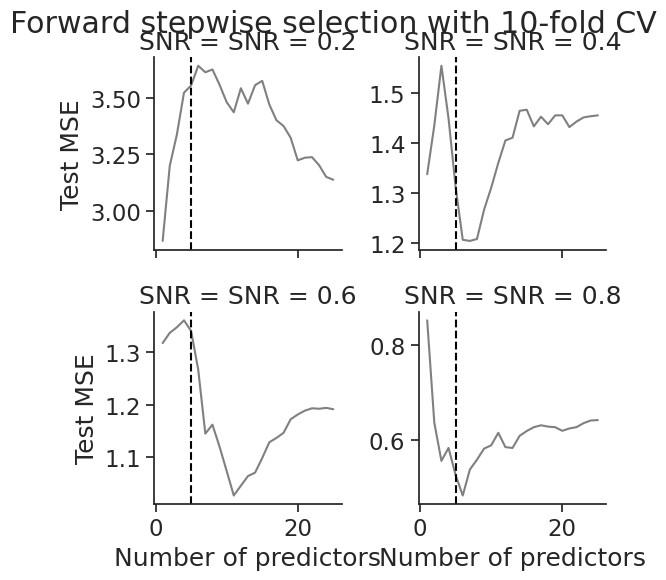

In [123]:
sns.set(style="ticks", font_scale=1.5)
g = sns.FacetGrid(data=err_cv, col="SNR", col_wrap=2, sharey=False)
g.map(sns.lineplot, "Size", "Test error", color="gray")
g.map(plt.axvline, x=p_true, color="black", linestyle="--")
g.set_axis_labels("Number of predictors", "Test MSE")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Forward stepwise selection with 10-fold CV")
plt.show()

### A wrong cross validation scheme

- Generate predictor variables $X$ and true response variable $y_0$.

- Divide the whole dataset into $K$ folds.

- For different $\text{SNR}$,
  
    - Generate noisy observations $y$.
    
    - Perform best subset selection using the whole dataset.
    
    - For $k = 1,\dots,K$,

        - Use the $k$-th fold as the test set to evaluate the prediction accuracy.
        
    - End.
  
- End.

In [124]:
N = 100
P = 25
p_true = 5
SNR_vec = [0.1, 0.3, 0.5, 0.7]

beta = np.zeros(P)
beta[:p_true] = 1

X = np.random.rand(N, P)
X = pd.DataFrame(X, columns=[f"X{i}" for i in range(1, P+1)])
y0 = X.dot(beta)

In [125]:
nfolds = 10
dat_idx = np.random.choice(N, N, replace=False)
err_cv = np.zeros((P, len(SNR_vec), nfolds))
for i in range(len(SNR_vec)):
    SNR = SNR_vec[i]
    y = y0 + np.random.normal(0, np.sqrt(np.var(y0) / SNR), N)
    dat = pd.concat([pd.DataFrame(y, columns=["y"]), X], axis=1)
    kf = KFold(n_splits=nfolds, shuffle=False)
    
    design = MS(dat.columns.drop('y')).fit(dat)
    strategy = Stepwise.fixed_steps(design,
                                len(design.terms),
                                direction='forward')
    full_path = sklearn_selection_path(OLS, strategy)
    
    full_path.fit(dat, dat.iloc[:, 0]) # Perform best subset selection using the whole dataset
    
    for k, (train_idx, test_idx) in enumerate(kf.split(dat)):
        pred = full_path.predict(dat.iloc[test_idx, :])
            
        err_cv[:, i, k] = ((pred[:, 1:] - np.array(dat.iloc[test_idx, 0]).reshape(len(test_idx),1))**2).mean(0)

In [127]:
err_cv = pd.DataFrame(err_cv.mean(axis=2), columns=["SNR = "+str(s) for s in SNR_vec])
err_cv["Size"] = np.arange(1, P+1)
err_cv = pd.melt(err_cv, id_vars=["Size"], var_name="SNR", value_name="Underestimated test error")

In [129]:
err_cv

,Size,SNR,Underestimated test error
0,1,SNR = 0.1,4.012614
1,2,SNR = 0.1,3.801231
2,3,SNR = 0.1,3.720377
3,4,SNR = 0.1,3.621409
4,5,SNR = 0.1,3.553148
...,...,...,...
95,21,SNR = 0.7,0.315477
96,22,SNR = 0.7,0.315444
97,23,SNR = 0.7,0.315438
98,24,SNR = 0.7,0.315435


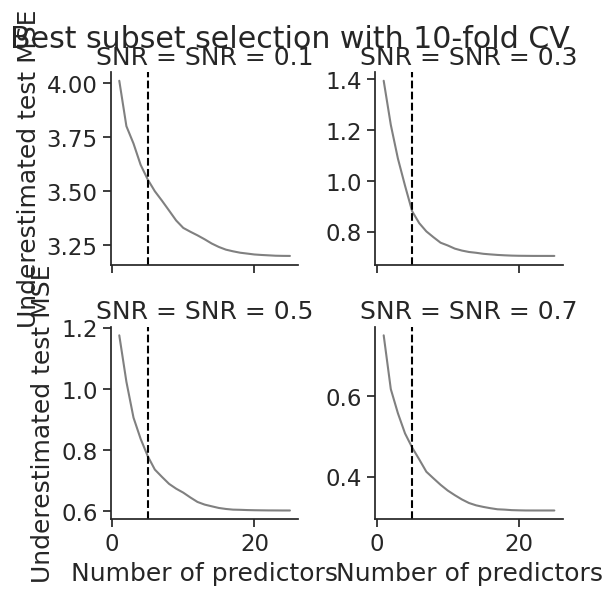

In [130]:
sns.set(style="ticks", font_scale=1.5)
g = sns.FacetGrid(data=err_cv, col="SNR", col_wrap=2, sharey=False)
g.map(sns.lineplot, "Size", "Underestimated test error", color="gray")
g.map(plt.axvline, x=p_true, color="black", linestyle="--")
g.set_axis_labels("Number of predictors", "Underestimated test MSE")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Best subset selection with 10-fold CV")
plt.show()